In [10]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
import matplotlib
import psycopg2
from sqlalchemy import create_engine
import jieba
from collections import Counter
from wordcloud import WordCloud
import requests
import urllib
import hashlib
import folium

In [2]:
conn_param = {
    'dbname': '***',
    'user': '***',
    'password': '***',
    'host': '***',
    'port': '***'
}

In [3]:
connection_string = f"postgresql://{conn_param['user']}:{conn_param['password']}@{conn_param['host']}:{conn_param['port']}/{conn_param['dbname']}"
engine = create_engine(f"postgresql+psycopg2://{conn_param['user']}:{conn_param['password']}@{conn_param['host']}:{conn_param['port']}/{conn_param['dbname']}")

In [4]:
df_1 = pd.read_csv(r"CSV FROM Tea_Spider", encoding="utf-8")
df_2 = pd.read_csv(r"CSV FROM Average_Province_Income", encoding="utf-8")

In [5]:
df_1.isnull().sum()

Product_Name      0
Product_Price     0
Product_Sales     0
Product_Origin    0
dtype: int64

In [6]:
df_2.isnull().sum()

省/市            0
GDP(万亿)        0
GDP同比(年度)      0
财政一般预算收入(亿)    0
财政一般预算支出(亿)    0
人均可支配收入(万)     0
人均消费支出(万)      0
常住人口(万)        0
dtype: int64

In [7]:
def parse_sales(sales_str):
    if pd.isna(sales_str):
        return None
    
    sales_str = str(sales_str).strip()
    
    match = re.search(r'(\d+(?:,\d+)?)(?:万)?(?:\+)?人', sales_str)
    
    if match:
        num_str = match.group(1).replace(',', '')
        num = float(num_str)
        
        if '万' in sales_str:
            num *= 10000
            
        return num
    else:
        print(f"No match for: {sales_str}")
        return None

In [8]:
df_1['Product_Sales'] = df_1['Product_Sales'].apply(parse_sales)

In [9]:
df_1.head()

,Product_Name,Product_Price,Product_Sales,Product_Origin
0,祁门红茶茶叶特级养胃官方旗舰店古树,49,2000.0,安徽
1,北京同仁堂赤小红豆薏米芡实茶非祛排湿气茯苓去除湿寒气毒养生茶,39,700000.0,湖南
2,西湖工夫杭州明前龙井2024新茶特级绿茶高档茶叶礼盒装送礼长辈,268,30000.0,浙江
3,猴王茉莉花茶浓香型特级横县茉莉绿茶红茶2024口粮茶袋装冷泡100g,10,900.0,浙江
4,信阳毛尖2024新茶明前特级嫩芽散装茶叶绿茶浓香型手工茶春茶250g,133,7000.0,河南


In [105]:
df_2 = df_2.rename(columns={"省/市": "Province_City"})

In [106]:
for df in [df_1, df_2]:
    df.columns = df.columns.str.lower()

In [107]:
df_1.to_sql("Tea", con = engine, if_exists='replace', index=False)
df_2.to_sql("Finance_CN", con = engine, if_exists='replace', index=False)

31

In [108]:
query = """
SELECT "Tea".*, "Finance_CN".* 
FROM "Tea"
JOIN "Finance_CN"
ON "Tea".product_origin = "Finance_CN".province_city;
"""

In [109]:
df_3 = pd.read_sql(query, con=engine)

In [110]:
df_3.drop('province_city', axis=1, inplace=True)

In [111]:
df_3.head()

,product_name,product_price,product_sales,product_origin,gdp(万亿),gdp同比(年度),财政一般预算收入(亿),财政一般预算支出(亿),人均可支配收入(万),人均消费支出(万),常住人口(万)
0,祁门红茶茶叶特级养胃官方旗舰店古树,49,2000.0,安徽,4.71,5.8,3939,8638,3.49,2.36,6121
1,北京同仁堂赤小红豆薏米芡实茶非祛排湿气茯苓去除湿寒气毒养生茶,39,700000.0,湖南,5.00,4.6,3361,9585,3.59,2.55,6568
2,西湖工夫杭州明前龙井2024新茶特级绿茶高档茶叶礼盒装送礼长辈,268,30000.0,浙江,8.26,6.0,8600,12353,6.38,4.22,6627
3,猴王茉莉花茶浓香型特级横县茉莉绿茶红茶2024口粮茶袋装冷泡100g,10,900.0,浙江,8.26,6.0,8600,12353,6.38,4.22,6627
4,信阳毛尖2024新茶明前特级嫩芽散装茶叶绿茶浓香型手工茶春茶250g,133,7000.0,河南,5.91,4.1,4512,11063,2.99,2.10,9815


In [112]:
tea_types = [
    '绿茶', '红茶', '乌龙茶', '白茶', '黄茶', '普洱茶', '花茶',
    '茉莉花茶', '铁观音', '龙井茶', '碧螺春', '大红袍', '安溪铁观音',
    '普洱熟茶', '普洱生茶', '红枣茶', '枸杞茶', '菊花茶', '罗汉果茶',
    '红梅茶', '冻顶乌龙', '玫瑰花茶', '桂花茶', '银针白毫', '仙草茶'
]

In [113]:
def replace_and_merge(description, tea_types):
    matched_types = set()
    
    for tea_type in tea_types:
        if tea_type in description:
            matched_types.add(tea_type)
    
    if matched_types:
        return ', '.join(matched_types)
    else:
        return None

In [114]:
df_3['product_name'] = df_3['product_name'].apply(lambda desc: replace_and_merge(desc, tea_types))

In [115]:
df_3 = df_3.dropna(subset=['product_name'])

In [116]:
df_3.head()

,product_name,product_price,product_sales,product_origin,gdp(万亿),gdp同比(年度),财政一般预算收入(亿),财政一般预算支出(亿),人均可支配收入(万),人均消费支出(万),常住人口(万)
0,红茶,49,2000.0,安徽,4.71,5.8,3939,8638,3.49,2.36,6121
2,绿茶,268,30000.0,浙江,8.26,6.0,8600,12353,6.38,4.22,6627
3,"红茶, 花茶, 绿茶, 茉莉花茶",10,900.0,浙江,8.26,6.0,8600,12353,6.38,4.22,6627
4,绿茶,133,7000.0,河南,5.91,4.1,4512,11063,2.99,2.10,9815
5,"龙井茶, 绿茶",29,800.0,浙江,8.26,6.0,8600,12353,6.38,4.22,6627


In [117]:
df_3.isnull().sum()

product_name      0
product_price     0
product_sales     0
product_origin    0
gdp(万亿)           0
gdp同比(年度)         0
财政一般预算收入(亿)       0
财政一般预算支出(亿)       0
人均可支配收入(万)        0
人均消费支出(万)         0
常住人口(万)           0
dtype: int64

In [118]:
comments = df_3['product_name']

In [119]:
def chinese_tokenizer(text):
    return jieba.lcut(text)

tokenized_comments = comments.apply(chinese_tokenizer)

In [120]:
word_counts = Counter([word for comment in tokenized_comments for word in comment])

In [121]:
wordcloud = WordCloud(
    font_path='msyh.ttc', 
    width=800,
    height=400,
    background_color='white'
).generate_from_frequencies(word_counts)

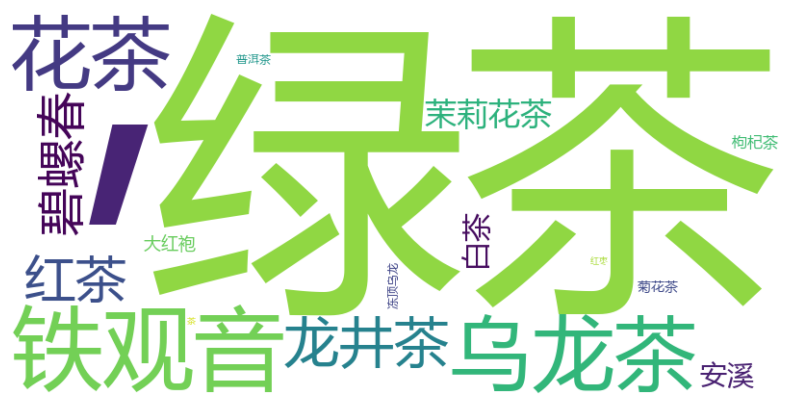

In [122]:
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [124]:
host = "https://api.map.baidu.com"
uri = "/geocoding/v3"
ak = "YOUR BAIDU AK"
sk = "YOUR BAIDU SK"

latitudes = []
longitudes = []

for area in df_3['product_origin']:
    params = {
        "address": area,
        "output": "json",
        "ak": ak,
    }
    
    paramsArr = []
    for key in params:
        paramsArr.append(f"{key}={params[key]}")
    
    queryStr = uri + "?" + "&".join(paramsArr)
    encodedStr = urllib.parse.quote(queryStr, safe="/:=&?#+!$,;'@()*[]")
    rawStr = encodedStr + sk
    sn = hashlib.md5(urllib.parse.quote_plus(rawStr).encode("utf8")).hexdigest()
    queryStr = queryStr + "&sn=" + sn
    url = host + queryStr
    
    response = requests.get(url)
    if response:
        data = response.json()
        if 'result' in data and 'location' in data['result']:
            latitudes.append(data['result']['location']['lat'])
            longitudes.append(data['result']['location']['lng'])
        else:
            latitudes.append(None)
            longitudes.append(None)
    else:
        latitudes.append(None)
        longitudes.append(None)

df_3['Latitude'] = latitudes
df_3['Longitude'] = longitudes

In [125]:
df_3.to_sql("Full_Tea_Table", con = engine, if_exists='replace', index=False)

221

In [130]:
df_3.dropna(subset=['Longitude','Latitude'],inplace=True)

In [134]:
df_3.head()

,product_name,product_price,product_sales,product_origin,gdp(万亿),gdp同比(年度),财政一般预算收入(亿),财政一般预算支出(亿),人均可支配收入(万),人均消费支出(万),常住人口(万),Latitude,Longitude
0,红茶,49,2000.0,安徽,4.71,5.8,3939,8638,3.49,2.36,6121,31.734294,117.330540
2,绿茶,268,30000.0,浙江,8.26,6.0,8600,12353,6.38,4.22,6627,30.271548,120.159533
3,"红茶, 花茶, 绿茶, 茉莉花茶",10,900.0,浙江,8.26,6.0,8600,12353,6.38,4.22,6627,30.271548,120.159533
4,绿茶,133,7000.0,河南,5.91,4.1,4512,11063,2.99,2.10,9815,34.771713,113.759384
5,"龙井茶, 绿茶",29,800.0,浙江,8.26,6.0,8600,12353,6.38,4.22,6627,30.271548,120.159533


In [140]:
import folium
from IPython.display import display


m = folium.Map(location=[df_3['Latitude'].mean(), df_3['Longitude'].mean()], zoom_start=5)

for _, row in df_3.iterrows():
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        icon=folium.Icon(
            color='blue',
            icon='info-sign',
            prefix='glyphicon'
        ),
        popup=folium.Popup(f"""
        <strong>Product Name:</strong> {row['product_name']}<br>
        <strong>Product Origin:</strong> {row['product_origin']}<br>
        <strong>Product Sales:</strong> {row['product_sales']}<br>
        <strong>人均可支配收入(万):</strong> {row['人均可支配收入(万)']}
        """, max_width=300)
    ).add_to(m)

html_file = r"YOUR SAVING PATH"
m.save(html_file)

display(m)
